In [1]:
import numpy as np
import pandas as pd
import os
from sklearn.datasets import load_files
import torch
from torchvision.datasets import ImageFolder
from torchvision import models, transforms, datasets
import torchvision
import torch.nn.functional as F

train_dir = './Training'
test_dir = './Test'

In [2]:
transforms_ = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5],
                         [0.5, 0.5, 0.5]) # normalize for pixel values to be between 0 and 1
])


train_data = datasets.ImageFolder(train_dir, transform=transforms_)
test_data = datasets.ImageFolder(test_dir, transform=transforms_)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=512, shuffle=True, num_workers = 12)
testloader = torch.utils.data.DataLoader(test_data, batch_size=300, shuffle=True)

len(trainloader.dataset)

67692

### Visualizing the training data

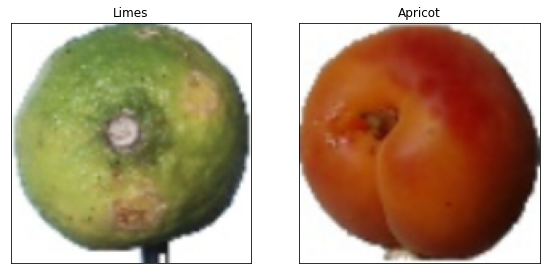

In [4]:
import matplotlib.pyplot as plt

data_iter = iter(trainloader)
images, labels = data_iter.next() 

fig = plt.figure(figsize=(25, 5))
for idx in range(2):
    ax = fig.add_subplot(1, 5, idx + 1, xticks=[], yticks=[])
    img = images[idx]/ 2 + 0.5
    npimg = img.numpy()
    img = np.transpose(npimg, (1, 2, 0)) #transpose
    ax.imshow(img, cmap='gray')
    ax.set_title(train_data.classes[labels[idx]])

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() 
                                  else "cpu")
device

device(type='cuda')

In [6]:
model = models.resnet50(pretrained=True)


In [7]:
import torch.nn as nn

In [8]:
for name, param in model.named_parameters():
    param.requires_grad = False

In [9]:
model.fc = nn.Linear(in_features=2048, out_features=len(train_data.classes), bias=True)

In [10]:
model.fc.parameters()

<generator object Module.parameters at 0x7f79fc45c550>

In [11]:
import torch.optim as optim
model = model.to(device)

criterion = nn.CrossEntropyLoss().cuda()
optimizer = optim.Adam(model.fc.parameters(), lr=0.003)



In [17]:
epochs = 10
steps = 0
running_loss = 0
print_every = 20
epoch_loss = 0
loss_values = []
for epoch in range(epochs):
    for inputs, labels in trainloader:
        steps += 1
        # Move input and label tensors to the default device
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad() # Zero the gradient for each batch
        
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        epoch_loss += loss.item() * inputs.size(0)
        if steps % print_every == 0:
            print(f"Epoch:{epoch + 1}/{epochs} Steps:{steps} Running Loss: {running_loss/print_every:.3f}")
            running_loss = 0
            model.train() #sets to training mode
    loss_values.append(epoch_loss / len(trainloader.dataset))
    epoch_loss = 0

Epoch:1/10 Steps:20 Running Loss: 2.084
Epoch:1/10 Steps:40 Running Loss: 1.836
Epoch:1/10 Steps:60 Running Loss: 1.826
Epoch:1/10 Steps:80 Running Loss: 1.775
Epoch:1/10 Steps:100 Running Loss: 1.851
Epoch:1/10 Steps:120 Running Loss: 1.618
Epoch:2/10 Steps:140 Running Loss: 1.444
Epoch:2/10 Steps:160 Running Loss: 1.361
Epoch:2/10 Steps:180 Running Loss: 1.301
Epoch:2/10 Steps:200 Running Loss: 1.253
Epoch:2/10 Steps:220 Running Loss: 1.252
Epoch:2/10 Steps:240 Running Loss: 1.321
Epoch:2/10 Steps:260 Running Loss: 1.211
Epoch:3/10 Steps:280 Running Loss: 1.058
Epoch:3/10 Steps:300 Running Loss: 1.000
Epoch:3/10 Steps:320 Running Loss: 0.982
Epoch:3/10 Steps:340 Running Loss: 0.939
Epoch:3/10 Steps:360 Running Loss: 0.861
Epoch:3/10 Steps:380 Running Loss: 0.874
Epoch:4/10 Steps:400 Running Loss: 0.853
Epoch:4/10 Steps:420 Running Loss: 0.827
Epoch:4/10 Steps:440 Running Loss: 0.741
Epoch:4/10 Steps:460 Running Loss: 0.763
Epoch:4/10 Steps:480 Running Loss: 0.719
Epoch:4/10 Steps:500

In [13]:
torch.save(model, './model.pth')

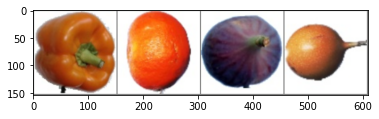

Pepper Orange Clementine Fig Granadilla


In [18]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(testloader)
images, labels = dataiter.next()
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images[100:104]))
print(' '.join(train_data.classes[idx] for idx in labels[100:104]))

In [20]:
correct = 0
total = 0
model.eval()
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy: {100 * correct / total}")

Accuracy: 98.98624823695346


In [25]:
model = model.to('cpu')
my_scripted_model = torch.jit.script(model)
torch.jit.save(my_scripted_model, 'model_jit.pt')


In [22]:
import json
with open('classes.json', 'w') as f:
    json.dump(train_data.classes, f)